# Import Library

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from spyre import server
import ipywidgets as widgets
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
%matplotlib inline
from ipywidgets import interactive

# 1. Data Pre-processing

## 1.1 Load Web Scraped and Web API’s Data

In [ ]:
data=pd.read_csv("WineDotCom.csv").iloc[:,1:]
data.head()
data2=pd.read_csv("TotalWine.csv").iloc[:,1:]
data3=pd.read_csv("AmazonAPI.csv").iloc[:,1:]

## 1.2 Data Cleaning

In [ ]:
def clean_title(value):
    value = str(value).split(',')[0]
    return value
data3['Title'] = data3['Title'].apply(clean_title)

def clean_price(value):
    value = str(value).replace(',', '').replace('$', '').strip()
    return float(value)
data2['Price'] = data2['Price'].apply(clean_price)
data3['Price'] = data2['Price'].apply(clean_price)

def clean_rating(value):
    value = str(value).replace('%', '').replace('width:', '').strip()
    return float(value)/100*5
data2['StarRating'] = data2['StarRating'].apply(clean_rating)

def clean_rater(value):
    if pd.isnull(value):
        return 0
    value = str(value).split('\t')[0][1:]
    return int(value)
data2['numRater'] = data2['numRater'].apply(clean_rater)

In [ ]:
data2.head()

In [ ]:
data3.head()

## 1.3 Data Mapping

In [ ]:
data_match1=pd.DataFrame(columns=['Title', 'Title2'])
titles=list(data2['Title'].unique())
for index in data.index:
    if pd.isnull(data.loc[index]['Year']):
        year=''
    else: year=str(int(data.loc[index]['Year']))
    for title in titles:
        if year in title:
            if fuzz.token_sort_ratio(data.loc[index]['Title'], title)>=90:
                data_match1=data_match1.append({'Title': data.loc[index]['Title'],'Title2': title},ignore_index=True)
                break

In [ ]:
data_match2=pd.DataFrame(columns=['Title', 'Title2'])
titles=list(data3['Title'].unique())
for index in data.index:
    for title in titles:
        if fuzz.token_set_ratio(data.loc[index]['Title'], title)==100:
            data_match2=data_match2.append({'Title': data.loc[index]['Title'],'Title2': title},ignore_index=True)
            break

In [ ]:
df1=pd.merge(data_match,data2,left_on='Title2',right_on='Title').drop('Title_y',1).rename(columns={'Title_x':'Title'})
df1['Website']='Total Wine'
df2=pd.merge(data_match2,data3,left_on='Title2',right_on='Title').drop('Title_y',1).rename(columns={'Title_x':'Title'})
df2['Website']='Amazon'
data_compare=df1.append(df2,sort=False)
data_compare.head()
data_compare.to_csv("data_compare.csv")

In [ ]:
data['minPrice']=data['Price']
minPrice=data['minPrice'].copy()
for index in data.index:
    m=data_compare[data_compare['Title']==data.loc[index]['Title']]['Price'].min()
    if not pd.isnull(m):
        minPrice[index]=min(data.loc[index]['minPrice'],m)
data['minPrice']=minPrice

In [ ]:
data['meanRating']=data['StarRating']
data['totalRater']=data['numRater']
meanRating=data['meanRating'].copy()
totalRater=data['totalRater'].copy()
for index in data.index:
    r=data_compare[data_compare['Title']==data.loc[index]['Title']]['StarRating'].mean()
    n=data_compare[data_compare['Title']==data.loc[index]['Title']]['numRater'].sum()
    if (not pd.isnull(r)) & (not pd.isnull(n)):
        totalRater[index]=data.loc[index]['numRater']+n
        meanRating[index]=(data.loc[index]['StarRating']*data.loc[index]['numRater']+r*n)/totalRater[index]
data['meanRating']=meanRating
data['totalRater']=totalRater
data.head()
data.to_csv("data.csv")

# 2. File Loading

## 2.1 Load csv 

In [14]:
data = pd.read_csv('data.csv',encoding='latin-1').iloc[:,1:]

## 2.2 Load Text File  

In [94]:
#View description of varietal
all_files = os.listdir("Varietal/") #suppose you are one directory above test dir
print(all_files)
txt_files = filter(lambda x: x[-4:] == '.txt', all_files) #filter out all the text files 
print(txt_files)
varietal_files = list(txt_files)

['Sherry.txt', 'Semillon.txt', 'Arneis.txt']


In [95]:
os.chdir("Varietal/")
varietal_intro = {}
for f in varietal_files :
    with open(f, 'r') as file:
        varietal_intro[f] = file.read()

In [96]:
varietal_intro['Sherry.txt']

'Dessert, Sherry & Port\nEnd a great meal on a sweet note, dessert and fortified wines come in an impressive array of styles and sweetness levels. Many wines in this category—including Port, Sherry, and Madeira—are fortified with neutral spirits to increase the level of alcohol, and, depending on the final style of wine desired, often to arrest fermentation while some (or a lot of) residual sugar remains. Others, like Sauternes and Tokaji, are produced by leaving the grapes on the vine long after the rest of the harvest has been processed in order to accumulate very high sugar levels. Often, a form of “noble” rot called botrytis plays a role, desiccating the grape until only the very flavorful solids and sugars remain. These late-picked wines are, accordingly, often referred to as late-harvest wines. In colder climates, the grapes may be allowed to freeze on the vine for the production of ice wine. '

In [97]:
os.chdir("..") #move up one directory

# 3. Statistical Analysis and Visualization

## 3.1 Price Analysis

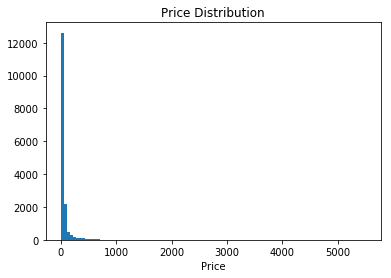

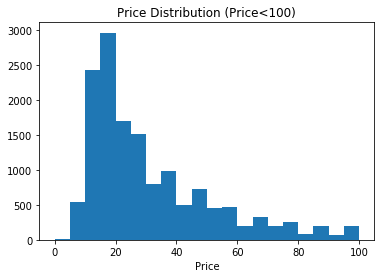

In [21]:
def PriceAnalysis():
    plt.hist(data['minPrice'],100)
    plt.xlabel('Price')
    plt.title('Price Distribution')
    plt.show()
    plt.hist(data[data['minPrice']<100]['minPrice'],20)
    plt.xlabel('Price')
    plt.title('Price Distribution (Price<100)')
    plt.show()
PriceAnalysis()

## 3.2 Varietal Analysis

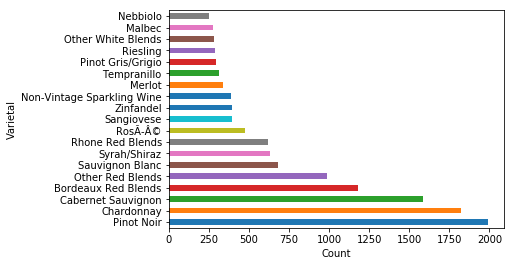

In [18]:
def varietalAnalysis():
    varietal=data.groupby(['Varietal']).size().sort_values(ascending=False)
    varietal[varietal>200].plot(kind="barh")
    plt.title('')
    plt.xlabel('Count')
varietalAnalysis()

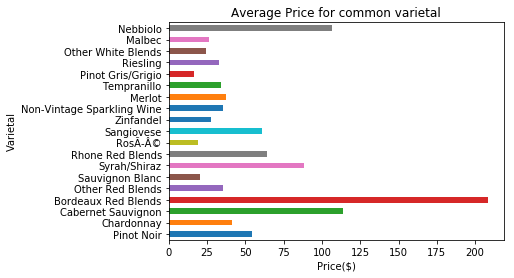

In [19]:
def varietal_price():
    varietal=data.groupby(['Varietal']).size().sort_values(ascending=False)
    df = data.groupby(['Varietal'])['minPrice'].agg(np.mean)
    varietal_price = pd.DataFrame(df)
    varietal_price
    df_new = pd.DataFrame(varietal[varietal>200])
    df_new.merge(varietal_price, left_index=True, right_index=True)['minPrice'].plot(kind="barh")
    plt.title('Average Price for common varietal')
    plt.xlabel('Price($)')
varietal_price()

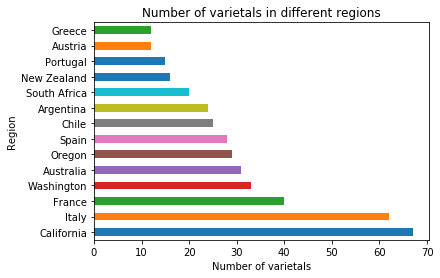

In [20]:
def varietal_country():
    varietal_country=data[['Country','Varietal']].drop_duplicates().groupby(['Country']).size().sort_values(ascending=False)
    varietal_country[varietal_country>10].plot(kind="barh")
    plt.title('Number of varietals in different regions')
    plt.xlabel('Number of varietals')
    plt.ylabel('Region')
varietal_country()

## 3.3 Region Analysis 

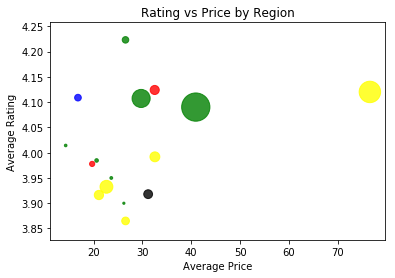

In [118]:
def regionAnalysis():
    wine = data[data["StarRating"]>0]
    count = pd.DataFrame(wine.groupby('Country').agg(['count'])['Title']).reset_index()
    avg_price = pd.DataFrame(wine.groupby('Country')['Price'].agg(['mean'])).reset_index()
    avg_star = pd.DataFrame(wine.groupby('Country')['StarRating'].agg(['mean'])).reset_index()
    count['avg_price'] = avg_price['mean']
    count['avg_star'] = avg_star['mean']
    count_revised =  count.loc[count['count'] >= 5].reset_index()
    col = ['yellow','black','green','yellow','yellow','green',
        'green','green','green','green','blue','green','red','red','yellow','yellow',
        'yellow','yellow','black','yellow','yellow','green','red','blue','green',
        'yellow','yellow']
    plt.title('Rating vs Price by Region')
    plt.xlabel('Average Price')
    plt.ylabel('Average Rating')
    plt.scatter(x = count_revised['avg_price'], y = count_revised['avg_star'], s = count_revised['count'], c = col, alpha = 0.8)

regionAnalysis()

## 3.4 Professional Rating Analysis 

In [106]:
def drop_columns(df, column_names):
    df = df.drop(column_names, axis = 1)
    return df
def get_groupby_counts(df, groups):
    result = df.groupby(groups).count()
    return result

In [199]:
df = drop_columns(data, ['Shopping_Link','Img_src'])
df = df[df["Professional Score"] > 0]

In [201]:
professional_tab = pd.crosstab(df["Professional Score"], df['Country'], margins = True)
professional_tab

Country,Argentina,Australia,Austria,California,Chile,China,France,Germany,Greece,Hungary,...,New York,New Zealand,Oregon,Other U.S.,Portugal,South Africa,Spain,Uruguay,Washington,All
Professional Score,,,,,,,,,,,,,,,,,,,,,
1.0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9.0,14,11,0,107,5,0,33,1,0,0,...,0,10,6,1,14,8,27,0,14,288
10.0,5,1,0,23,1,0,19,0,0,0,...,0,1,1,0,7,1,8,0,4,83
88.0,0,0,0,4,0,0,2,0,0,0,...,0,0,0,0,0,1,3,0,1,11
89.0,2,6,0,46,2,0,15,0,0,0,...,0,8,3,0,4,2,5,0,10,108
90.0,0,0,0,2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,4
91.0,12,9,1,77,13,0,68,2,1,0,...,3,7,10,1,9,0,13,2,9,267
92.0,11,13,0,81,11,0,70,1,1,0,...,0,3,4,0,7,2,23,0,13,275
93.0,5,4,0,64,3,1,44,1,0,0,...,1,0,1,0,8,0,14,0,2,182


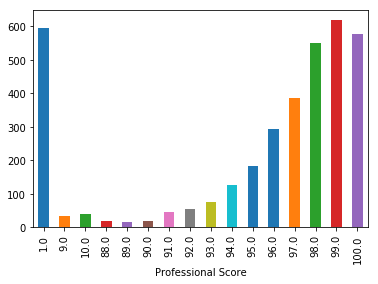

In [117]:
def professionalRating():
    professional_rating_price = df.groupby(['Professional Score']).Price.mean()
    professional_rating_price.plot.bar()
professionalRating()

## 3.5 Buyers Rating Analysis 

In [200]:
#buyer ratings Crosstab
df = drop_columns(data, ['Shopping_Link','Img_src'])
df = df[df["StarRating"] > 0]
buyer_tab = pd.crosstab(df.StarRating, df.Year, margins = True)
buyer_tab
rating25 = pd.DataFrame(buyer_tab[3:4] + buyer_tab[0:1].values + buyer_tab[1:2].values + buyer_tab[2:3].values, columns = buyer_tab[0:1].columns)
rating25
rating30 = pd.DataFrame(buyer_tab[4:5].values + buyer_tab[5:6].values + buyer_tab[6:7].values + buyer_tab[7:8].values + buyer_tab[8:9], columns = buyer_tab[0:1].columns)
rating30
rating35 = pd.DataFrame(buyer_tab[9:10].values + buyer_tab[10:11].values + buyer_tab[11:12].values + buyer_tab[12:13].values + buyer_tab[13:14], columns = buyer_tab[0:1].columns)
rating35
rating40 = pd.DataFrame(buyer_tab[14:15].values + buyer_tab[15:16].values + buyer_tab[16:17].values + buyer_tab[17:18].values + buyer_tab[18:19], columns = buyer_tab[0:1].columns)
rating40
rating45 = pd.DataFrame(buyer_tab[19:20].values + buyer_tab[20:21].values + buyer_tab[21:22].values + buyer_tab[22:23].values + buyer_tab[23:24], columns = buyer_tab[0:1].columns)
rating45
rating50 = pd.DataFrame(buyer_tab[24:25].values + buyer_tab[25:26].values + buyer_tab[26:27].values + buyer_tab[27:28].values + buyer_tab[28:29], columns = buyer_tab[0:1].columns)
rating50
allogate_crosstab = rating25.append(rating30)
allogate_crosstab = allogate_crosstab.append(rating35)
allogate_crosstab = allogate_crosstab.append(rating40)
allogate_crosstab = allogate_crosstab.append(rating45)
allogate_crosstab = allogate_crosstab.append(rating50)
allogate_crosstab

Year,1927.0,1994.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,...,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,All
StarRating,,,,,,,,,,,,,,,,,,,,,
2.6,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,2,0,6
3.1,0,0,0,0,0,0,0,1,0,0,...,1,2,1,3,5,9,9,4,0,35
3.6,0,0,0,0,0,0,0,0,1,0,...,2,4,9,10,27,45,81,62,11,253
4.1,0,0,1,1,1,1,0,2,1,1,...,4,3,12,38,77,179,212,195,40,770
4.6,1,0,3,0,0,0,1,6,5,2,...,15,12,22,29,72,149,173,154,49,695
All,1,2,4,1,7,3,1,13,11,7,...,24,30,46,91,205,437,518,467,130,2005


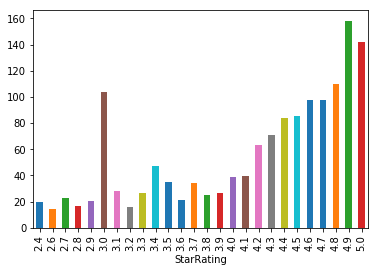

In [116]:
def buyerRating():
    star_rating_price = df.groupby(['StarRating']).Price.mean()
    star_rating_price.plot.bar()
buyerRating()

## 3.6 Popularity Analysis 

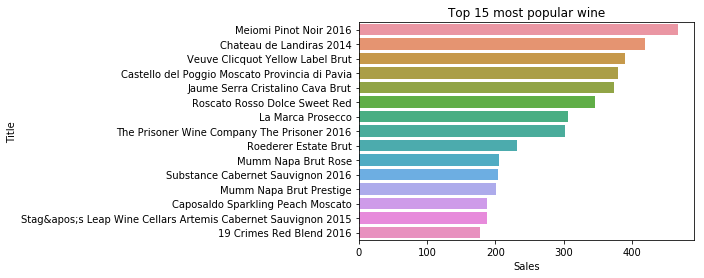

In [184]:
def popularityAnalysis():
    df = data.loc[:,['Title','numRater']]
    new_df = df.sort_values('numRater', ascending=False).head(15)
    sns.barplot(x='numRater', y='Title', data=new_df, orient='h')
    plt.title('Top 15 most popular wine')
    plt.xlabel('Sales')
popularityAnalysis()

# 4. Overview for Users

In [188]:
plot0 = interactive(popularityAnalysis)
plot1 = interactive(varietalAnalysis)
plot2 = interactive(varietal_price)
plot3 = interactive(varietal_country)
plot4 = interactive(regionAnalysis)
plot5 = interactive(professionalRating)
plot6 = interactive(buyerRating)

In [189]:
children = [plot0,plot1, plot2, plot3, plot4,plot5,plot6]
tab = widgets.Tab()
tab.children = children
tab.set_title(0, 'Popular Wine')
tab.set_title(1, 'Varietal vs Price')
tab.set_title(2, 'Varietal vs Region')
tab.set_title(3, 'Region Overview')
tab.set_title(4, 'Professional Ratings Overview')
tab.set_title(5, 'Buyers Ratings Overview')
tab

Tab(children=(interactive(children=(Output(),), _dom_classes=('widget-interact',)), interactive(children=(Output(),), _dom_classes=('widget-interact',)), interactive(children=(Output(),), _dom_classes=('widget-interact',)), interactive(children=(Output(),), _dom_classes=('widget-interact',)), interactive(children=(Output(),), _dom_classes=('widget-interact',)), interactive(children=(Output(),), _dom_classes=('widget-interact',)), interactive(children=(Output(),), _dom_classes=('widget-interact',))), _titles={'0': 'Popular Wine', '1': 'Varietal vs Price', '2': 'Varietal vs Region', '3': 'Region Overview', '4': 'Professional Ratings Overview', '5': 'Buyers Ratings Overview'})

# 5. Recommendation System

## --Recommend Products based on Users' prefernces

## 5.1 Search by Title 

In [131]:
Search = widgets.Text(
    value= None,
    placeholder='Type something',
    description='Search:',
    disabled=False
)
Search

Text(value='', description='Search:', placeholder='Type something')

In [136]:
product_idx = {}
booleanVal_product=[None] * len(data)
for i in range(0, len(data)):
    ratio = fuzz.ratio(Search.value, data.ix[i,'Title'])
    partial_ratio = fuzz.partial_ratio(Search.value, data.ix[i,'Title'])
    token_ratio = fuzz.token_sort_ratio(Search.value,data.ix[i,'Title'])
    if ratio == 100: 
        print(str(i) + ' ' +data.ix[i,'Title'])
        product_idx[i] = ratio
        booleanVal_product[i] = True
    else:
        if partial_ratio >= 90:
            print(str(i) + ' ' +data.ix[i,'Title'])
            product_idx[i] = partial_ratio
            booleanVal_product[i] = True
        elif token_ratio >= 90:
            print(str(i) + ' ' +data.ix[i,'Title'])
            product_idx[i] = token_ratio
            booleanVal_product[i] = True
        else:
            booleanVal_product[i] = False

5 Silver Oak Napa Valley Cabernet Sauvignon 2013
133 Hall Napa Valley Cabernet Sauvignon 2014
163 Hall Napa Valley Cabernet Sauvignon 2015
1497 Silver Oak Napa Valley Cabernet Sauvignon (1.5 Liter Magnum) 2013
2043 Silver Oak Napa Valley Cabernet Sauvignon (1.5 Liter Magnum) 1996
3893 Ramey Cabernet Sauvignon 2014
4788 Selby Cabernet Sauvignon 2013
10131 Silver Oak Napa Valley Cabernet Sauvignon (3 Liter) 1998
12055 Silver Oak Napa Valley Cabernet Sauvignon (3 Liter Bottle) 2013
12401 Laely Cabernet Sauvignon 2012
12434 Silver Oak Napa Valley Cabernet Sauvignon (6 Liter Bottle) 2013
14028 Silver Oak Napa Valley Cabernet Sauvignon (3 Liter Bottle) 1993
14152 Silver Oak Napa Valley Cabernet Sauvignon (3 Liter Bottle) 1992
14403 Silver Oak Napa Valley Cabernet Sauvignon (6 Liter) 1998
14531 Silver Oak Napa Valley Cabernet Sauvignon (1.5 Liter Magnum) 1994
14811 Silver Oak Napa Valley Cabernet Sauvignon (6 Liter - signs of past seepage) 1988


In [134]:
df = data
df = df.loc[booleanVal_product,:]
df_product = pd.DataFrame(product_idx, index=['score']).T.sort_values(by='score',ascending=False)

In [135]:
index = list(df_product.index)
df_display = data.ix[index,['Title', 'Price', 'Professional Score', 'StarRating','numRater']]
df_display

,Title,Price,Professional Score,StarRating,numRater
5,Silver Oak Napa Valley Cabernet Sauvignon 2013,114.99,94.0,4.5,102
1497,Silver Oak Napa Valley Cabernet Sauvignon (1.5...,274.97,94.0,NaN,0
2043,Silver Oak Napa Valley Cabernet Sauvignon (1.5...,255.97,91.0,NaN,0
10131,Silver Oak Napa Valley Cabernet Sauvignon (3 L...,599.97,NaN,NaN,0
12055,Silver Oak Napa Valley Cabernet Sauvignon (3 L...,674.97,94.0,NaN,0
14028,Silver Oak Napa Valley Cabernet Sauvignon (3 L...,639.97,NaN,NaN,0
14152,Silver Oak Napa Valley Cabernet Sauvignon (3 L...,549.97,94.0,NaN,0
14531,Silver Oak Napa Valley Cabernet Sauvignon (1.5...,306.97,92.0,NaN,0
133,Hall Napa Valley Cabernet Sauvignon 2014,54.99,92.0,4.2,46
163,Hall Napa Valley Cabernet Sauvignon 2015,59.99,93.0,NaN,0


## Compare Prices 

In [ ]:
df_display.iloc[0,:]

## 5.2 Search by Varietal 

In [137]:
selectVarietal = widgets.Dropdown(
    options=['Sherry', 'Semillon', 'Arneis'],
    value = None,
    description='Varietal:'
)
selectVarietal

Dropdown(description='Varietal:', options=('Sherry', 'Semillon', 'Arneis'), value=None)

In [139]:
#Display Introduction
varietal_filename = selectVarietal.value+".txt"
varietal_intro[varietal_filename]

"Semillon\nA shy but noble variety with considerable structure, depth, and length, beneath Sémillon’s aloof exterior lays a singular, uncompromising white with the power and intensity to create wines that can last and improve for several decades. It is the perfect partner to tame Sauvignon Blanc's wild side in its most important outpost of Bordeaux. Sémillon especially shines in Sauternes, one of the world’s greatest sweet wines, with highly concentrated flavors of honey and dried apricots. While Sémillon is not the most fashionable grape in the rest of the wine world, it has had great success in Australia, where it can produce elegant, complex dry wines.\nIn the Glass\n\nSémillon is most notable for its oily texture and significant palate weight. In youthful dry wines, it expresses subtle aromas of lemon, green apple, pear, and stone fruit. Aged or sweet Sémillon wines show more complex character of lanolin, beeswax, honeysuckle, ginger, saffron, vanilla, or toast.\nPerfect Pairings\n

In [141]:
df = data
if selectVarietal.value: 
    boolVal_varietal = (df['Varietal'] == selectVarietal.value)
else:
    boolVal_varietal = (df['Varietal'] != 0)
    print("No result")
df.loc[boolVal_varietal,:]
#boolVal_varietal

,Unnamed: 0,Title,Year,Varietal,Price,Region,Country,Score_WS,Score_RP,Score_W&S,...,Score_V,Score_JD,Professional Score,StarRating,numRater,Shopping_Link,Img_src,minPrice,meanRating,totalRater
2091,2091,Silkman Semillon 2016,2016.0,Semillon,22.99,Hunter Valley,Australia,NaN,91.0,NaN,...,NaN,NaN,91.0,NaN,0,https://www.wine.com/product/Silkman-Semillon-...,https://www.wine.com/product/images/fl_progres...,22.99,0.0,0
2177,2177,Stony Hill Semillon de Soleil (375ML half-bott...,2014.0,Semillon,29.99,Napa Valley,California,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,https://www.wine.com/product/Stony-Hill-Semill...,https://www.wine.com/product/images/fl_progres...,29.99,0.0,0
3551,3551,Ricardo Santos Semillon 2017,2017.0,Semillon,17.99,Mendoza,Argentina,92.0,NaN,NaN,...,NaN,NaN,92.0,NaN,0,https://www.wine.com/product/Ricardo-Santos-Se...,https://www.wine.com/product/images/fl_progres...,17.99,0.0,0
3624,3624,Tyrrell&apos;s Hunter Valley Semillon 2016,2016.0,Semillon,22.99,Hunter Valley,Australia,90.0,NaN,NaN,...,NaN,NaN,9.0,NaN,0,https://www.wine.com/product/Tyrrells-Hunter-V...,https://www.wine.com/product/images/fl_progres...,22.99,0.0,0
4591,4591,Brokenwood Hunter Valley Semillon 2016,2016.0,Semillon,20.99,Hunter Valley,Australia,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,https://www.wine.com/product/Brokenwood-Hunter...,https://www.wine.com/product/images/fl_progres...,20.99,0.0,0
4598,4598,Smith Story Lakota&apos;s View Semillon 2016,2016.0,Semillon,45.99,Sonoma County,California,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,https://www.wine.com/product/Smith-Story-Lakot...,https://www.wine.com/product/images/fl_progres...,45.99,0.0,0
5052,5052,Tyrrell&apos;s Hunter Valley Semillon 2017,2017.0,Semillon,19.99,Hunter Valley,Australia,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,https://www.wine.com/product/Tyrrells-Hunter-V...,https://www.wine.com/product/images/fl_progres...,19.99,0.0,0
5899,5899,Ashbrook Estate Semillon 2015,2015.0,Semillon,19.99,Margaret River,Australia,NaN,NaN,NaN,...,NaN,NaN,92.0,NaN,0,https://www.wine.com/product/Ashbrook-Estate-S...,https://www.wine.com/product/images/fl_progres...,19.99,0.0,0
6943,6943,Ricardo Santos Semillon 2016,2016.0,Semillon,18.99,Mendoza,Argentina,NaN,NaN,NaN,...,NaN,NaN,89.0,NaN,0,https://www.wine.com/product/Ricardo-Santos-Se...,https://www.wine.com/product/images/fl_progres...,18.99,0.0,0
7934,7934,Andis Semillon 2016,2016.0,Semillon,22.99,Sierra Foothills,California,NaN,NaN,NaN,...,NaN,NaN,9.0,NaN,0,https://www.wine.com/product/Andis-Semillon-20...,https://www.wine.com/product/images/fl_progres...,22.99,0.0,0


## 5.3 Search by Price Range 

In [142]:
selectPrice = widgets.FloatRangeSlider(
    value=None,
    min=0,
    max=5500.0,
    step=0.1,
    description='Price Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
selectPrice

FloatRangeSlider(value=(1375.0, 4125.0), continuous_update=False, description='Price Range:', max=5500.0)

In [145]:
selectPrice.value
minPrice = selectPrice.value[0]
maxPrice = selectPrice.value[1]
df = data

boolVal_price = (df['Price']>=minPrice) & (df['Price']<=maxPrice)
df.loc[boolVal_price,:]

,Unnamed: 0,Title,Year,Varietal,Price,Region,Country,Score_WS,Score_RP,Score_W&S,...,Score_V,Score_JD,Professional Score,StarRating,numRater,Shopping_Link,Img_src,minPrice,meanRating,totalRater
50,50,Chateau Margaux 2015,2015.0,Bordeaux Red Blends,1699.97,Bordeaux,France,99.0,99.0,NaN,...,NaN,100.0,100.0,NaN,0,https://www.wine.com/product/Chateau-Margaux-2...,https://www.wine.com/product/images/fl_progres...,1699.97,0.0,0
205,205,Chateau Lafite Rothschild (1.5 Liter Magnum) 2015,2015.0,Bordeaux Red Blends,1499.97,Bordeaux,France,NaN,96.0,NaN,...,NaN,96.0,97.0,NaN,0,https://www.wine.com/product/Chateau-Lafite-Ro...,https://www.wine.com/product/images/fl_progres...,1499.97,0.0,0
6612,6612,Chateau Cheval Blanc 1943,1943.0,Bordeaux Red Blends,3999.97,Bordeaux,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,https://www.wine.com/product/Chateau-Cheval-Bl...,https://www.wine.com/product/images/fl_progres...,3999.97,0.0,0
6814,6814,Chateau Petrus 2014,2014.0,Bordeaux Red Blends,2399.99,Bordeaux,France,95.0,93.0,NaN,...,NaN,NaN,95.0,NaN,0,https://www.wine.com/product/Chateau-Petrus-20...,https://www.wine.com/product/images/fl_progres...,2399.99,0.0,0
7213,7213,Fontodi Flaccianello della Pieve (6 Liter Bott...,2010.0,Sangiovese,1499.98,Tuscany,Italy,NaN,97.0,NaN,...,NaN,NaN,97.0,NaN,0,https://www.wine.com/product/Fontodi-Flacciane...,https://www.wine.com/product/images/fl_progres...,1499.98,0.0,0
7569,7569,Chateau Lafite Rothschild 1996,1996.0,Bordeaux Red Blends,1599.97,Bordeaux,France,96.0,100.0,NaN,...,NaN,NaN,98.0,NaN,0,https://www.wine.com/product/Chateau-Lafite-Ro...,https://www.wine.com/product/images/fl_progres...,1599.97,0.0,0
7878,7878,Chateau Petrus (Futures Pre-Sale) 2017,2017.0,Bordeaux Red Blends,2699.97,Bordeaux,France,NaN,95.0,NaN,...,97.0,NaN,96.0,NaN,0,https://www.wine.com/product/Chateau-Petrus-Fu...,https://www.wine.com/product/images/fl_progres...,2699.97,0.0,0
7999,7999,Chateau Petrus 1987,1987.0,Bordeaux Red Blends,2499.97,Bordeaux,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,https://www.wine.com/product/Chateau-Petrus-19...,https://www.wine.com/product/images/fl_progres...,2499.97,0.0,0
8882,8882,Chateau Petrus 2003,2003.0,Bordeaux Red Blends,2999.97,Bordeaux,France,98.0,95.0,NaN,...,NaN,NaN,97.0,NaN,0,https://www.wine.com/product/Chateau-Petrus-20...,https://www.wine.com/product/images/fl_progres...,2999.97,0.0,0
10245,10245,Chateau Petrus 1993,1993.0,Bordeaux Red Blends,2399.97,Bordeaux,France,95.0,NaN,NaN,...,NaN,NaN,95.0,NaN,0,https://www.wine.com/product/Chateau-Petrus-19...,https://www.wine.com/product/images/fl_progres...,2399.97,0.0,0


## 5.4 Search by Region 

In [147]:
selectRegion = widgets.Dropdown(
    options= list(data['Country'].unique()),
    value = None,
    description='Region:'
)
selectRegion

Dropdown(description='Region:', options=('California', 'France', 'Italy', 'Spain', 'Washington', 'Other', 'Portugal', 'Oregon', nan, 'New Zealand', 'Australia', 'Argentina', 'Chile', 'South Africa', 'New Mexico', 'Germany', 'Greece', 'Uruguay', 'Canada', 'New York', 'Japan', 'Austria', 'Macedonia (FYROM)', 'China', 'Slovenia', 'Hungary', 'England', 'Lebanon', 'Brazil', 'Israel', 'Other U.S.', 'Croatia', 'Virginia', 'Turkey'), value=None)

In [148]:
if selectRegion.value:
    boolVal_region = (df['Country'] == selectRegion.value)
    df.loc[boolVal_region,:]
else:
    boolVal_region = (df['Country'] != 0)
    print("No results matched")

No results matched


## 5.5 Search by Year 

In [149]:
selectYear = widgets.IntRangeSlider(
    value=[1927, 2018],
    min=1927,
    max=2018,
    step=1,
    description='Year Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
selectYear

IntRangeSlider(value=(1927, 2018), continuous_update=False, description='Year Range:', max=2018, min=1927)

In [150]:
df = data
minYear = selectYear.value[0]
maxYear = selectYear.value[1]
boolVal_yr = (df['Year'] >= minYear) & (df['Year'] <= maxYear)
boolVal_yr
df.loc[boolVal_yr,:]

,Unnamed: 0,Title,Year,Varietal,Price,Region,Country,Score_WS,Score_RP,Score_W&S,...,Score_V,Score_JD,Professional Score,StarRating,numRater,Shopping_Link,Img_src,minPrice,meanRating,totalRater
0,0,Caymus Napa Valley Cabernet Sauvignon 2016,2016.0,Cabernet Sauvignon,79.99,Napa Valley,California,NaN,NaN,NaN,...,NaN,NaN,92.0,4.4,59,https://www.wine.com/product/Caymus-Napa-Valle...,https://www.wine.com/product/images/fl_progres...,79.99,4.400000,59
1,1,Dom Perignon with Gift Box 2009,2009.0,Vintage Sparkling Wine,189.97,Champagne,France,96.0,NaN,NaN,...,NaN,NaN,96.0,4.2,110,https://www.wine.com/product/Dom-Perignon-with...,https://www.wine.com/product/images/fl_progres...,189.97,4.200000,110
2,2,Ornellaia 2015,2015.0,Bordeaux Red Blends,219.99,Tuscany,Italy,97.0,NaN,NaN,...,98.0,NaN,98.0,3.5,5,https://www.wine.com/product/Ornellaia-2015/40...,https://www.wine.com/product/images/fl_progres...,219.99,3.500000,5
3,3,Rombauer Chardonnay 2017,2017.0,Chardonnay,36.99,Carneros,California,NaN,NaN,NaN,...,NaN,NaN,91.0,4.9,9,https://www.wine.com/product/Rombauer-Chardonn...,https://www.wine.com/product/images/fl_progres...,36.99,4.900000,9
4,4,Domaine de la Janasse Chateauneuf-du-Pape Cuve...,2016.0,Grenache,79.99,Rhone,France,95.0,97.0,NaN,...,NaN,99.0,97.0,NaN,0,https://www.wine.com/product/Domaine-de-la-Jan...,https://www.wine.com/product/images/fl_progres...,79.99,0.000000,0
5,5,Silver Oak Napa Valley Cabernet Sauvignon 2013,2013.0,Cabernet Sauvignon,114.99,Napa Valley,California,NaN,NaN,NaN,...,NaN,NaN,94.0,4.5,102,https://www.wine.com/product/Silver-Oak-Napa-V...,https://www.wine.com/product/images/fl_progres...,114.99,4.500000,102
7,7,Tour Saint Christophe Les Terrasses de Saint C...,2014.0,Bordeaux Red Blends,21.99,Bordeaux,France,NaN,NaN,NaN,...,NaN,NaN,92.0,3.9,70,https://www.wine.com/product/Tour-Saint-Christ...,https://www.wine.com/product/images/fl_progres...,21.99,3.900000,70
8,8,Tua Rita Redigaffi Toscana 2015,2015.0,Merlot,299.99,Tuscany,Italy,95.0,97.0,NaN,...,NaN,NaN,98.0,NaN,0,https://www.wine.com/product/Tua-Rita-Redigaff...,https://www.wine.com/product/images/fl_progres...,299.99,0.000000,0
9,9,Duckhorn Napa Valley Cabernet Sauvignon 2015,2015.0,Cabernet Sauvignon,64.99,Napa Valley,California,NaN,NaN,NaN,...,NaN,NaN,92.0,4.4,39,https://www.wine.com/product/Duckhorn-Napa-Val...,https://www.wine.com/product/images/fl_progres...,64.99,4.400000,39
10,10,Joseph Phelps Insignia 2014 6 Pack OWC,2014.0,Mixed Collections,1200.00,Napa Valley,California,NaN,97.0,NaN,...,NaN,NaN,97.0,NaN,0,https://www.wine.com/product/Joseph-Phelps-Ins...,https://www.wine.com/product/images/fl_progres...,1200.00,0.000000,0


## 5.6 Search by Taste 

In [151]:
selectTaste = widgets.Dropdown(
    options= [],
    value = None,
    description='Taste:'
)
selectTaste

Dropdown(description='Taste:', options=(), value=None)

## 5.7 Search by Varietal, Year, Taste and Region

In [154]:
boolVal_yr
boolVal_price
boolVal_varietal
boolVal_region

boolVal = []
for i in range(0, len(data)):
    boolVal.append(all([boolVal_yr[i], boolVal_price[i],boolVal_varietal[i],boolVal_region[i]]))
df = data    
boolVal
if len(df.loc[boolVal,:])>0: df.loc[boolVal,:]
else: print("No Results Matched")
       

No Results Matched


# 6. Recommend Similar Items

In [51]:
def find_similar_items(search_title):
    i=data[data['Title']==search_title].index[0]
    similar_list=pd.DataFrame(columns=['Title','Score'])
    for index in data.index:
        if index!=i:
            score=0
            r1=fuzz.token_sort_ratio(data.loc[index]['Title'], search_title)
            r2=fuzz.token_set_ratio(data.loc[index]['Title'], search_title)                        
            if max(r1,r2)>=80:
                score+=max(r1,r2)
            score+=max(0,10-abs(data.loc[index]['Year']-data.loc[i]['Year']))*5
            score+=min(data.loc[index]['Price'],data.loc[i]['Price'])/max(data.loc[index]['Price'],data.loc[i]['Price'])*50
            if data.loc[index]['Varietal']==data.loc[i]['Year']:
                score+=50
#             r1=fuzz.token_sort_ratio(data.loc[index]['Taste'], data.loc[i]['Taste'])
#             r2=fuzz.token_set_ratio(data.loc[index]['Taste'], data.loc[i]['Taste'])
#             score+=max(r1,r2)/2
            if data.loc[index]['Country']==data.loc[i]['Country']:
                score+=50   
            if data.loc[index]['Region']==data.loc[i]['Region']:
                score+=30  
            similar_list=similar_list.append({'Title': data.loc[index]['Title'],'Score': score},ignore_index=True)
    similar_items=similar_list.sort_values(by='Score',ascending=False).iloc[:20,:1].merge(data,on='Title')                      
    return similar_items
find_similar_items('Rombauer Chardonnay 2017')                                

,Title,Year,Varietal,Price,Region,Country,Score_WS,Score_RP,Score_W&S,Score_JH,...,Score_D,Score_V,Score_JD,StarRating,numRater,Shopping_Link,Img_src,minPrice,meanRating,totalRater
0,Lloyd Chardonnay 2017,2017.0,Chardonnay,38.99,Carneros,California,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0,https://www.wine.com/product/Lloyd-Chardonnay-...,https://www.wine.com/product/images/fl_progres...,38.99,0.0,0
1,Rombauer Chardonnay (375ML half-bottle) 2017,2017.0,Chardonnay,19.99,Carneros,California,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0,https://www.wine.com/product/Rombauer-Chardonn...,https://www.wine.com/product/images/fl_progres...,19.99,0.0,0
2,Rombauer Chardonnay (1.5 Liter Magnum) 2017,2017.0,Chardonnay,81.97,Carneros,California,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0,https://www.wine.com/product/Rombauer-Chardonn...,https://www.wine.com/product/images/fl_progres...,81.97,0.0,0
3,Rombauer Chardonnay (3 Liter Bottle) 2017,2017.0,Chardonnay,199.97,Carneros,California,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0,https://www.wine.com/product/Rombauer-Chardonn...,https://www.wine.com/product/images/fl_progres...,199.97,0.0,0
4,Oberon Chardonnay 2016,2016.0,Chardonnay,22.99,Carneros,California,90.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0,https://www.wine.com/product/Oberon-Chardonnay...,https://www.wine.com/product/images/fl_progres...,22.99,0.0,0
5,Quilt Chardonnay 2017,2017.0,Chardonnay,33.99,Napa Valley,California,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0,https://www.wine.com/product/Quilt-Chardonnay-...,https://www.wine.com/product/images/fl_progres...,33.99,0.0,0
6,AERENA Chardonnay 2017,2017.0,Chardonnay,23.99,Sonoma County,California,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0,https://www.wine.com/product/AERENA-Chardonnay...,https://www.wine.com/product/images/fl_progres...,23.99,0.0,0
7,Materra Chardonnay 2016,2016.0,Chardonnay,26.99,Napa Valley,California,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0,https://www.wine.com/product/Materra-Chardonna...,https://www.wine.com/product/images/fl_progres...,26.99,0.0,0
8,Camp Chardonnay 2017,2017.0,Chardonnay,17.99,Sonoma County,California,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0,https://www.wine.com/product/Camp-Chardonnay-2...,https://www.wine.com/product/images/fl_progres...,17.99,0.0,0
9,Simi Chardonnay 2017,2017.0,Chardonnay,14.99,Sonoma County,California,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0,https://www.wine.com/product/Simi-Chardonnay-2...,https://www.wine.com/product/images/fl_progres...,14.99,0.0,0
